# Part II - Loan Data from Prosper  Analysis
## by Mmenyene

## Investigation Overview


> I analyzed this project from an investor's point of view, and I wanted to figure out which borrower's features were the best indicators of having the highest rate of return.

## Dataset Overview

> There are 113,937 loans in the dataset with 81 features. Most variables are numeric and categorical in nature.

> The dataset features can be split into two main categories:
> - Borrower information
> - Loan performance information

In [4]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


## Distribution of Estimated Returns by Loan Status

> For the current loans, there appears to be a large number of loans that have an actual return value of 0. This could mean that "Current" also takes into account all the loans that have not been fully funded yet. We would have to explore this further to extract loans that have been fully funded.

>Since our actual returns feature is not annualized, we see that for the loan terms of 3-5 years, an investor could see a total return of 170%.

>For loans that have defaulted or have been chargedoff, it makes sense that a majority of them show negative returns up to 100%. Meaning that the borrower could have never made a payment or the service/collection fees resulted in the investor losing their entire principal. Of course this is the worst case scenario. It's reassuring to see that this occurs in a minority of the loans, however it is nonzero and has a significant impact on an investors portfolio if they are diversified over several notes.



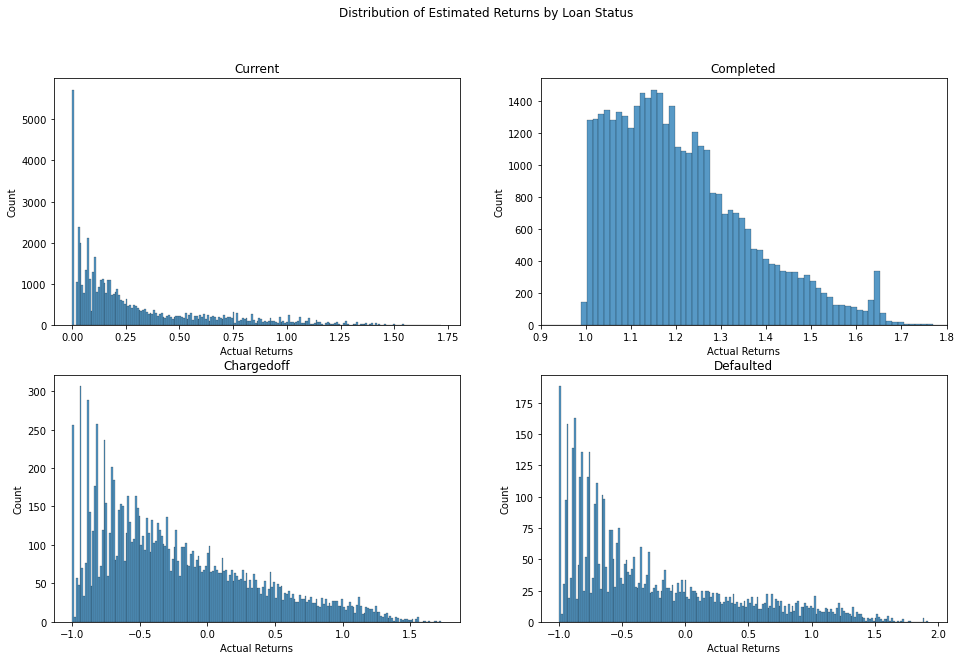

In [6]:

# simplified actual return formula
df['ActualReturns'] = df.LP_CustomerPayments - df.LoanOriginalAmount - (df.LP_ServiceFees + df.LP_CollectionFees + df.LP_NetPrincipalLoss)
df['ActualReturns'] = 1 + (df.ActualReturns / df.LoanOriginalAmount)

# multiplot for loan status

variables = ['Current', 'Completed', 'Chargedoff', 'Defaulted']

plt.figure(figsize = [16, 10])

# loop through variables list
for i in range(len(variables)):
    plt.subplot(2, 2, i+1)
    
    sns.histplot(df.query('LoanStatus == "{}"'.format(variables[i])).ActualReturns, 
                 kde = False, bins = 200)
    
    plt.xlabel('Actual Returns')
    plt.ylabel('Count')
    plt.title(variables[i])
    
plt.subplot(2, 2, 2)
plt.xlim(.9, 1.8)

plt.suptitle('Distribution of Estimated Returns by Loan Status');

## Plot of Estimated Returns, Actual Returns, and Debt to Income Ratios

> When comparing the pair correlation between numeric features of interest, it was interesting to find that there doesn't seem to be any correlation between them. You may intuitively expect borrowers with a high debt to income ratio to be riskier and thus have a lower rate of return - but that doesn't appear to be the case.

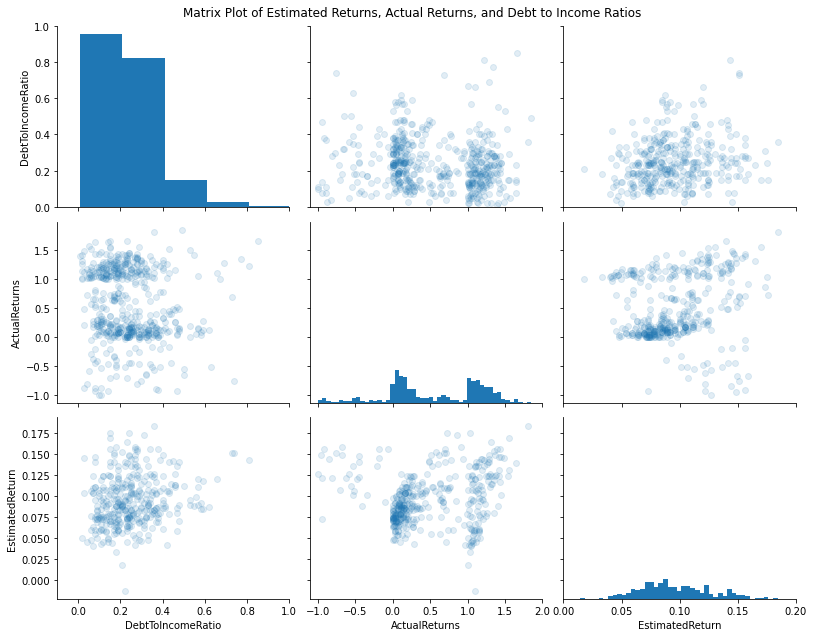

In [7]:
# numeric and categorical variables
numeric_vars = ['DebtToIncomeRatio', 'ActualReturns', 'EstimatedReturn']
categoric_vars = ['IncomeRange', 'ProsperRatingCombined']


# plot matrix with 0.5% of data points
samples = np.random.choice(df.shape[0], int(df.shape[0]*.005), replace = False)
df_samp = df.loc[samples,:]

# pair grid
g = sns.PairGrid(data = df_samp, vars = numeric_vars, height = 3, aspect = 1.25)
g = g.map_diag(plt.hist, bins = 50)
g.map_offdiag(plt.scatter, alpha = 1/8)

# set axis limits
g.axes[0,0].set_ylim(0,1)
g.axes[0,0].set_xlim(-.1,1)
g.axes[0,1].set_xlim(-1.1,2)
g.axes[0,2].set_xlim(0,.2)

g.fig.suptitle('Matrix Plot of Estimated Returns, Actual Returns, and Debt to Income Ratios')
g.fig.subplots_adjust(top = .95);

## How borrower's income range and credit rating relates to the investor's estimated returns.

> We can observe that the median estimated return decrease ad the borrower's income increases. We can also see from the credit ratings that as the borrower's credit increases, the median estimated significantly decreases. It may be right to speculate that logically, as income increase, the ability for loan repayment also increases. Therefore, to adjust for the higher risk, it makes sense for the interest rate for the loan to also increase. It's normal to find taht creditors would compete for these high income borrowers which drives the highest credit rating interest rates down. One more thing here is that we can see that the width and whiskers of the boxplots shrinks as credit rating increases. This means that the expected returns for this feature are more predictable than the lower credit ratings.

>It seems that investing in borrowers with no reported income and highest credit ratings will result in the highest returns.

In [11]:
# replace NC with HR
df['CreditGrade'].replace(['NC', 'HR'], 'E', inplace = True)

# fill NA with empty strings
df['ProsperRating (Alpha)'].fillna("", inplace = True)
df['CreditGrade'].fillna("", inplace = True)

# combine credit ratings
df['ProsperRatingCombined'] = df['ProsperRating (Alpha)'] + df['CreditGrade']

# drop rows with no credit ratings
df = df.query(' ProsperRatingCombined != ""')

In [14]:
# convert string to ordinal category type
ordinal_rating = ['AA', 'A', 'B', 'C', 'D', 'E']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_rating)
df['ProsperRatingCombined'] = df['ProsperRatingCombined'].astype(ordered_var)

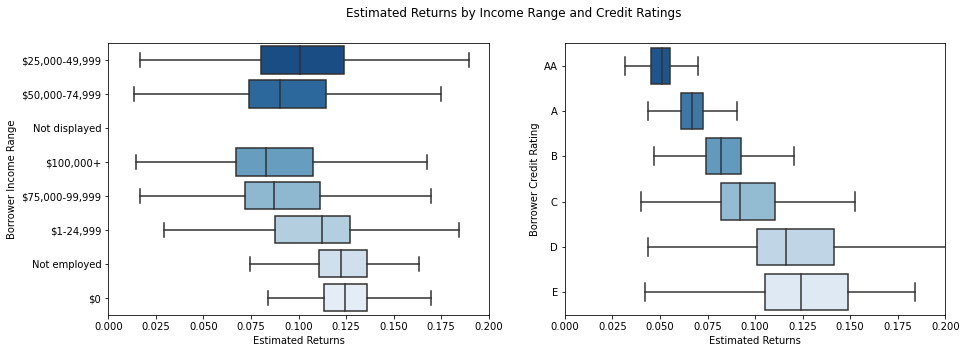

In [15]:
# boxplots
plt.figure(figsize = [15, 5])

plt.subplot(1, 2, 1)
base_color = sns.color_palette()[0]
sns.boxplot(data = df, y = 'IncomeRange', x = 'EstimatedReturn', palette = "Blues_r", showfliers = False)
plt.xlim(0,.2)
plt.ylabel('Borrower Income Range')
plt.xlabel('Estimated Returns')

plt.subplot(1, 2, 2)
base_color = sns.color_palette()[0]
sns.boxplot(data = df, y = 'ProsperRatingCombined', x = 'EstimatedReturn', palette = "Blues_r", showfliers = False)
plt.xlim(0,.2)
plt.ylabel('Borrower Credit Rating')
plt.xlabel('Estimated Returns')

plt.suptitle('Estimated Returns by Income Range and Credit Ratings');


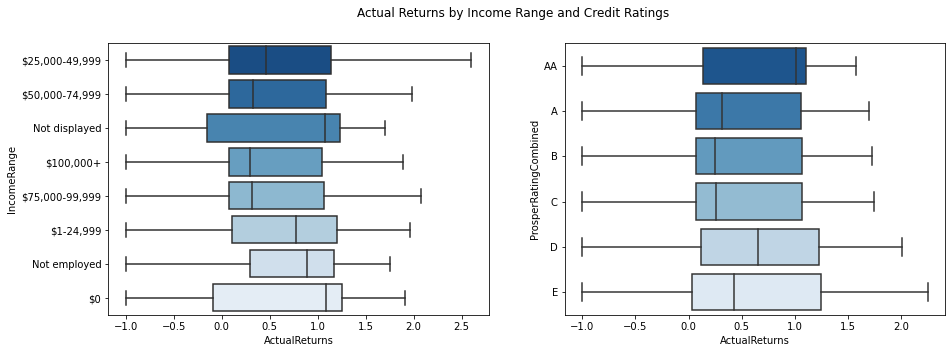

In [16]:
# boxplots
plt.figure(figsize = [15, 5])

plt.subplot(1, 2, 1)
base_color = sns.color_palette()[0]
sns.boxplot(data = df, y = 'IncomeRange', x = 'ActualReturns', palette = "Blues_r", showfliers = False)

plt.subplot(1, 2, 2)
base_color = sns.color_palette()[0]
sns.boxplot(data = df, y = 'ProsperRatingCombined', x = 'ActualReturns', palette = "Blues_r", showfliers = False);

plt.suptitle('Actual Returns by Income Range and Credit Ratings');

In [24]:
!jupyter nbconvert <Part II - Loan Data from Prosper Analysis>.ipynb --to slides --post serve --no-input --no-prompt

The system cannot find the file specified.
